# Adam Thomson - PHY 574 - Week 2

### Measurement Error Mitigation
Follow the qiskit notebook for measurement error mitigation https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/measurement-error-mitigation.ipynb
- Copy the code to follow along
- Add comments and change the inputs, describe results

In [92]:
# import libraries
from collections import defaultdict
from IPython.display import Math
import numpy as np
import scipy.linalg as la

from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram

# Initialize local simulator
sampler = AerSimulator()

# Declare shortcut function
def dm(x):
    return display(Math(x))

For this notebook, we will be focusing on handling error between measurement and return to the user. This can be modelled fairly simply by preparing each possible state and then taking an immediate measurement - we can then check which qubits were flipped in the results.

In [93]:
# define noise model util generator
def get_noise(p):
    error_meas = pauli_error([('X', p), ('I', 1-p)])  # Apply an X gate with p probability
    
    noise_model = NoiseModel()      # instantiate the noise model
    # Apply our error to measurement steps
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")

    return noise_model

Let's take a closer look at the 2-qubit example for p=1%

In [6]:
# Construct p=0.01 noise model
noise_model = get_noise(0.01)

In [94]:
# Prepare each possible 2-qubit state and then measure
counts_2q = {}
qcs_2q = []
STATES_2Q = ['00', '01', '10', '11']
for state in STATES_2Q:
    qc = QuantumCircuit(2,2)   # construct a circuit for this state
    
    # Prepare the intended state by applying X gates
    if state[0] == '1':
        qc.x(1)
    if state[1] == '1':
        qc.x(0)

    # Measure the qubits
    qc.measure(qc.qregs[0], qc.cregs[0])
    
    # Add this circuit to the list of 2-qubit state preparations
    qcs_2q.append(qc)

    # Run a 10K sampling
    state_counts = sampler.run([qc], noise_model=noise_model, shots=10000).result().get_counts()
    
    # Add the counts to a dict for later
    counts_2q[state] = state_counts

    # Print the results
    print(state + ' becomes', state_counts)

00 becomes {'11': 1, '01': 99, '10': 109, '00': 9791}
01 becomes {'10': 1, '00': 99, '01': 9788, '11': 112}
10 becomes {'11': 102, '00': 113, '10': 9785}
11 becomes {'00': 2, '10': 123, '01': 101, '11': 9774}


Increasing our p_meas should have a direct impact on these counts, let's verify.

In [95]:
# repeat with p=20% instead
noise_model_p20 = get_noise(0.2)
# Store the counts for later
counts_p20 = {}
for state in STATES_2Q:
    qc = QuantumCircuit(2,2)   # construct a circuit for this state
    
    # Prepare the intended state by applying X gates
    if state[0] == '1':
        qc.x(1)
    if state[1] == '1':
        qc.x(0)

    # Measure the qubits
    qc.measure(qc.qregs[0], qc.cregs[0])
    
    # Run a 10k sampling
    p20_counts = sampler.run([qc], noise_model=noise_model_p20, shots=10000).result().get_counts()
    
    # Add the counts to a dict for later
    counts_p20[state] = p20_counts

    # Print the results
    print(state + ' becomes', p20_counts)

00 becomes {'11': 403, '01': 1572, '00': 6404, '10': 1621}
01 becomes {'10': 410, '00': 1568, '11': 1585, '01': 6437}
10 becomes {'01': 393, '00': 1529, '10': 6460, '11': 1618}
11 becomes {'01': 1565, '00': 405, '10': 1589, '11': 6441}


Indeed, we are much more likely than before to measure a result other than the intended state that was prepared.

Let's examine the results for a bell state such as (|00> + |11>)

In [97]:
# Prepare a Bell state and examine measurements
qc = QuantumCircuit(2,2)
qc.h(0)     # Apply H-gate
qc.cx(0,1)  # Apply CX-gate with superposition control
qc.measure(qc.qregs[0], qc.cregs[0])
bell_counts = sampler.run([qc], noise_model=noise_model, shots=10000).result().get_counts()
print(bell_counts)


{'01': 92, '11': 4826, '10': 111, '00': 4971}


We measure `00` and `11` most often with similar probability, but theoretically `01` and `10` should never be measured - how can we mitigate this? 

### Error mitigation with linear algebra

We can describe our measurement counts as a vector:

In [98]:
# Represent Bell state measurements as vector
dm(r"C_{B} = \begin{pmatrix} {c00} \\ {c01} \\ {c10} \\ {c11} \end{pmatrix}"
    .replace("{c00}", str(bell_counts['00']))
    .replace("{c01}", str(bell_counts['01']))
    .replace("{c10}", str(bell_counts['10']))
    .replace("{c11}", str(bell_counts['11']))
)

<IPython.core.display.Math object>

By inputting this vector into a normalized matrix of the combined noisy basis state measurement, we can return to an idealized count vector. Let's take a closer look at this by using the notebook example.

In [99]:
# Calc C_noisy for the Bell state

# copy the normalized noise matrix provided by qiskit
M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

# our expected results with no noise, |00> + |11>
Cideal = [[5000],
          [0],
          [0],
          [5000]]

# Apply the noise matrix to the ideal state
Cnoisy = np.dot(M, Cideal)
# Show our expected noisy state
print('C_noisy =\n', Cnoisy)

C_noisy =
 [[4904.5]
 [ 101. ]
 [  91.5]
 [4903. ]]


This is the opposite of what we want - so instead, we use the inverse matrix and apply it to our measured count vector.

In [100]:
# find the inverse of M
Minv = la.inv(M)  # Use the inverse function from linear algebra library
print(Minv)

[[ 1.01978044e+00 -1.11470783e-02 -9.87135367e-03  1.05228426e-04]
 [-9.89772783e-03  1.02188470e+00  9.39504466e-05 -1.11514471e-02]
 [-9.97422955e-03 -4.05845410e-06  1.01913199e+00 -9.04172099e-03]
 [ 9.15212840e-05 -1.07335657e-02 -9.35458279e-03  1.02008794e+00]]


In [101]:
# Apply to our noisy measurement counts
Cmitigated = np.dot(Minv, Cnoisy)
dm(r"""C_{mitigated} = \begin{pmatrix}
    {Cm0} \\ {Cm1} \\ {Cm2} \\ {Cm3}
\end{pmatrix}"""
   .replace('{Cm0}', str(Cmitigated[0][0]))
   .replace('{Cm1}', str(Cmitigated[1][0]))
   .replace('{Cm2}', str(Cmitigated[2][0]))
   .replace('{Cm3}', str(Cmitigated[3][0]))
)

<IPython.core.display.Math object>

When rounded to an integer for counts, this exactly matches the ideal!

### Error mitigation in qiskit

Although the `qiskit_utils.mitigation` module is deprecated in the current version of qiskit, we'll follow the rest of the example as best we can. The replacement library `qiskit-addon-mthree` is designed specifically to hide the underlying matrix math and would make the rest of the exercise moot.

Let's use the circuit for `p=20%` from earlier to examine these results further.

In [105]:
# Run Bell circuit using the p=0.2 noise model
qc = QuantumCircuit(2,2)
qc.h(0)     # Apply H-gate
qc.cx(0,1)  # Apply CX-gate with superposition control
qc.measure(qc.qregs[0], qc.cregs[0])
bell_p20_counts = sampler.run([qc], noise_model=noise_model_p20, shots=10000).result().get_counts()
print(bell_p20_counts)

{'11': 3366, '01': 1581, '10': 1610, '00': 3443}


We see a significant increase in occurances of |01> and |10> in the counts, does the technique still hold?

In [103]:
# Calculate C_noisy and Minv_p20

# Parse the counts from earlier into a normalized matrix
M_p20 = [
    [counts_p20['00'][i]/10000 for i in STATES_2Q],
    [counts_p20['01'][i]/10000 for i in STATES_2Q],
    [counts_p20['10'][i]/10000 for i in STATES_2Q],
    [counts_p20['11'][i]/10000 for i in STATES_2Q]
]

# Apply the noise matrix to the ideal Bell state
Cnoisy_p20 = np.dot(M_p20, Cideal)
dm(r"C_{noisy_{p20}} = \begin{pmatrix} {Cnoisy_p20} \end{pmatrix}"
    .replace("{Cnoisy_p20}", (r' \\ ').join([str(i[0]) for i in Cnoisy_p20])))

# Calculate the inverse noise matrix
Minv_p20 = la.inv(M_p20)
print(Minv_p20)

<IPython.core.display.Math object>

[[ 1.76560652 -0.43006536 -0.44191059  0.10636943]
 [-0.42707605  1.75640451  0.10171779 -0.43104625]
 [-0.41579087  0.10131436  1.7540043  -0.43952779]
 [ 0.09532605 -0.42471435 -0.42964251  1.75903081]]


In [106]:
# Calculated the mitigated state
Cmit_p20 = np.dot(Minv_p20, [[bell_p20_counts[i]] for i in STATES_2Q])
dm(r"""C_{mitigated_{p20}} = \begin{pmatrix}
    {Cm0} \\ {Cm1} \\ {Cm2} \\ {Cm3}
\end{pmatrix}"""
   .replace('{Cm0}', str(Cmit_p20[0][0]))
   .replace('{Cm1}', str(Cmit_p20[1][0]))
   .replace('{Cm2}', str(Cmit_p20[2][0]))
   .replace('{Cm3}', str(Cmit_p20[3][0]))
)

<IPython.core.display.Math object>

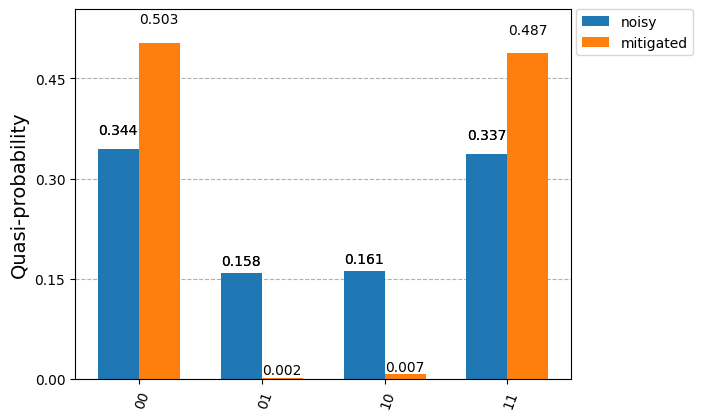

In [107]:
# plot the results
mitigated_p20_counts = defaultdict(int)
for i, j in enumerate(STATES_2Q):
    mitigated_p20_counts[j] = Cmit_p20[i][0]
plot_histogram([bell_p20_counts, mitigated_p20_counts], legend=['noisy', 'mitigated'])

Even with a larger probability of error, we can still rely on this method for error mitigation. We've taken a circuit with over 30% chance of measuring a value other than what we expect, and reduced that to less than 1% by applying the inverted noise matrix!